**Ques - Implement a feature extraction model using GLCM (Gray Level Co-occurence Matrix). On the basis of extracted features classfiy the images of the uploaded dataset. Here, I am using the tumor, non-tumor dataset for classifcation.**

Load the dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving MRI.zip to MRI.zip


In [3]:
!unzip MRI.zip

Archive:  MRI.zip
   creating: MRI/
   creating: MRI/Non-Tumor/
  inflating: MRI/Non-Tumor/Tr-no_0010.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0011.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0012.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0013.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0014.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0015.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0016.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0017.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0018.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0019.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0020.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0021.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0022.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0023.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0024.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0025.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0026.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0027.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0028.jpg  
  inflating: MRI/Non-Tumor/Tr-no_0029.jpg  
   creating: MRI/Tumor/
  inflating: MRI/Tumor/Tr-me_001

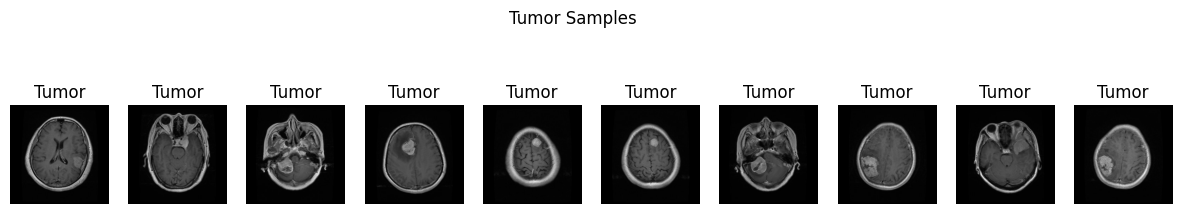

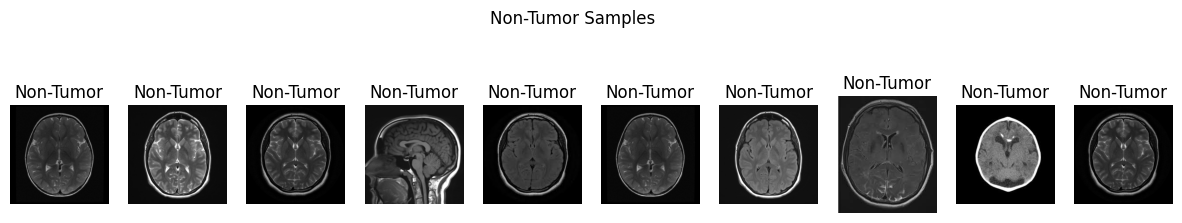

In [4]:
import matplotlib.pyplot as plt
import cv2
import os

def display_images(folder_path, label, max_images=10):
    files = os.listdir(folder_path)
    total = min(len(files), max_images)

    plt.figure(figsize=(15, 3))
    for idx, file in enumerate(files[:total]):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, total, idx+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.suptitle(f"{label} Samples")
    plt.show()

# Change path if needed:
display_images("/content/MRI/Tumor", "Tumor")
display_images("/content/MRI/Non-Tumor", "Non-Tumor")

Extract the GLCM features for each image


Label images (tumor = 1, Non-tumor = 0)


Split the dataset into training and testing



In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# GLCM feature extractor function
def compute_glcm_features(img, dx=1, dy=0, levels=8):
    img = cv2.resize(img, (128, 128))
    img = (img / (256 / levels)).astype(int)

    glcm = np.zeros((levels, levels), dtype=np.float64)
    rows, cols = img.shape
    for i in range(rows - dy):
        for j in range(cols - dx):
            row_val = img[i][j]
            col_val = img[i + dy][j + dx]
            glcm[row_val][col_val] += 1

    glcm_sum = glcm.sum()
    if glcm_sum > 0:
        glcm /= glcm_sum

    # Extract features
    contrast = np.sum([(i - j) ** 2 * glcm[i, j] for i in range(levels) for j in range(levels)])
    energy = np.sum(glcm**2)
    homogeneity = np.sum([glcm[i, j] / (1 + abs(i - j)) for i in range(levels) for j in range(levels)])
    entropy = -np.sum([glcm[i, j] * np.log2(glcm[i, j] + 1e-10) for i in range(levels) for j in range(levels)])

    return [contrast, energy, homogeneity, entropy]

# Load and label images
def load_dataset(path):
    features = []
    labels = []

    for label_name in ['Tumor', 'Non-Tumor']:
        folder = os.path.join(path, label_name)
        label = 1 if label_name == 'Tumor' else 0

        for filename in tqdm(os.listdir(folder), desc=f"Processing {label_name}"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            feats = compute_glcm_features(img)
            features.append(feats)
            labels.append(label)

    return np.array(features), np.array(labels)

# Load your dataset
X, y = load_dataset("/content/MRI")

print("\nDataset Loaded!")
print("\nFull Feature Vector Shape:", X.shape)
print("Labels Shape:", y.shape)

# Print the full feature vectors and labels (first 10 samples)
print("\nFirst 10 Feature Vectors and Labels:")
for i in range(min(10, len(X))):
    print(f"Sample {i+1} - Features: {X[i]}, Label: {'Tumor' if y[i] == 1 else 'Non-Tumor'}")

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\nDataset Split!")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Print 10 training samples
print("\n10 Training Samples:")
for i in range(min(10, len(X_train))):
    print(f"Train Sample {i+1} - Features: {X_train[i]}, Label: {'Tumor' if y_train[i] == 1 else 'Non-Tumor'}")

Processing Non-Tumor: 100%|██████████| 20/20 [00:01<00:00, 17.38it/s]


Dataset Loaded!

Full Feature Vector Shape: (40, 4)
Labels Shape: (40,)

First 10 Feature Vectors and Labels:
Sample 1 - Features: [0.3972687  0.39187415 0.91459681 2.31962148], Label: Tumor
Sample 2 - Features: [0.42605807 0.37623121 0.90092274 2.49959651], Label: Tumor
Sample 3 - Features: [0.46801181 0.42452996 0.89975555 2.46087303], Label: Tumor
Sample 4 - Features: [0.31373031 0.42463651 0.93176322 2.149365  ], Label: Tumor
Sample 5 - Features: [0.14997539 0.54168216 0.93856525 1.87647431], Label: Tumor
Sample 6 - Features: [0.17667323 0.48973264 0.93515215 2.01671686], Label: Tumor
Sample 7 - Features: [0.33747539 0.43619548 0.91228733 2.257542  ], Label: Tumor
Sample 8 - Features: [0.21099902 0.47693282 0.94204294 1.93187593], Label: Tumor
Sample 9 - Features: [0.36441929 0.43189558 0.92265684 2.19088322], Label: Tumor
Sample 10 - Features: [0.18430118 0.4957855  0.93928806 1.96215114], Label: Tumor

Dataset Split!
Training samples: 28
Testing samples: 12

10 Training Samples:

Trainig the classifier Logistic Regression on the dataset and predicting whether the given input image belongs to Tumor or Non-Tumor category

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.6647
Epoch 200, Loss: 0.6470
Epoch 300, Loss: 0.6318
Epoch 400, Loss: 0.6186
Epoch 500, Loss: 0.6071
Epoch 600, Loss: 0.5970
Epoch 700, Loss: 0.5882
Epoch 800, Loss: 0.5804
Epoch 900, Loss: 0.5735
Accuracy : 83.33%


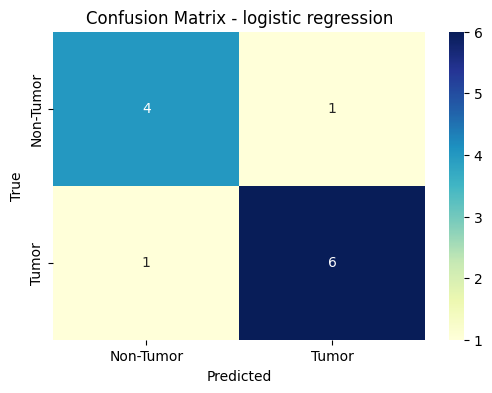

In [10]:
import numpy as np

#Sigmoid activation function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

#Loss function i.e binary cross entropy
def compute_loss(y, y_pred):
  epsilon = 1e-10 # to avoid log(0)
  return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

#Training function
def train_logistic_regression(X, y, lr=0.01, epochs=1000):
  n_samples, n_features = X.shape
  weights = np.zeros(n_features)
  bias = 0

  for epoch in range(epochs):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)

    #Gradient calculation
    dw = np.dot(X.T, (y_pred - y)) / n_samples
    db = np.mean(y_pred - y)

    #Update weights
    weights -= lr * dw
    bias -= lr * db

    #print loss every 100 epochs
    if epoch % 100 == 0:
      loss = compute_loss(y, y_pred)
      print(f"Epoch {epoch}, Loss: {loss:.4f}")

  return weights, bias

#Prediction function
def predict(X, weights, bias):
  linear_model = np.dot(X, weights) + bias
  y_pred = sigmoid(linear_model)
  return [1 if i >= 0.5 else 0 for i in y_pred]


#Train the model
weights, bias = train_logistic_regression(X_train, y_train, lr = 0.05, epochs=1000)

#predict on the test set
y_pred = predict(X_test, weights, bias)

#accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc * 100:.2f}%")

#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Non-Tumor","Tumor"], yticklabels=["Non-Tumor","Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - logistic regression")
plt.show()